# 1 Target: ventana temporal de chequeo

El problema que tenemos es que cada usuario que puede llegar a tener un credito lo tiene en diferentes momentos en comparación a los demas. Sin embargo, no es la misma ventana de transaccionalibilidad para todos.

In [13]:
!ls -l

total 36
-rw-r--r-- 1 fede fede  9313 Oct 26 09:04 01-grupos.ipynb
-rw-r--r-- 1 fede fede 17718 Oct 26 07:04 02_titanic.ipynb
drwxr-xr-x 2 fede fede  4096 Oct 26 07:09 data


In [14]:
!ls data

users.csv


In [15]:
!pwd

/home/fede/code/UCEMA_2023/part-3/4-clasificacion/03_dataset_completos


In [1]:
import pandas as pd
path_data = "data/"
# Cargar los DataFrames de usuarios y transacciones
users_df = pd.read_csv(path_data + 'users.csv')

In [2]:
users_df.shape

(21215, 19)

In [3]:
users_df.shape

(21215, 19)

In [22]:
users_df[users_df.id_cliente == -254861][["fecha_orden","target"]]

,fecha_orden,target
0,2022-10-06,0
1,2022-11-16,0
2,2022-12-03,0
3,2022-12-17,1
4,2023-01-18,0


In [15]:
users_df.head(2)

,Unnamed: 0,target,id_cliente,orden_nro,ciudad,monto,segmento,microsegmento,fecha_orden,fecha_de_vencimiento,fecha_de_pago,order_closed_cohort,ord_due_cohort,payment_cohort,dif_pymt_date,dow_closed,cantidad_sesiones,tiempo_promedio_navegacion,days_ultima_navegacion
0,0,0,-254861,71455943905963,BOG,277133.55,restaurante,cafetería,2022-10-06,2022-10-13,2022-10-12,2022-10-01,2022-10-01,2022-10-01,-1.0,3,21,614.333333,1.0
1,1,0,-254861,52135310417582,BOG,299324.79,restaurante,cafetería,2022-11-16,2022-11-23,2022-12-01,2022-11-01,2022-11-01,2022-12-01,8.0,2,23,642.130435,1.0


In [11]:
users_df.segmento.value_counts(dropna=False)

restaurante    18375
hogar           1495
comercio        1068
duplicated       199
institución       72
fraud              5
na                 1
Name: segmento, dtype: int64

In [ ]:
users_df

### Analisis

Tengo dos variables para analizar. El target. 

In [42]:
users_df["target"].value_counts()

0    17782
1     3433
Name: target, dtype: int64

In [41]:
users_df.groupby(["segmento"]).agg(cantidad=("target","sum"))

,cantidad
segmento,
comercio,186
duplicated,37
fraud,0
hogar,327
institución,11
na,0
restaurante,2872


In [43]:
users_df.groupby(["segmento"]).agg(cantidad=("target","mean"))

,cantidad
segmento,
comercio,0.174157
duplicated,0.185930
fraud,0.000000
hogar,0.218729
institución,0.152778
na,0.000000
restaurante,0.156299


In [19]:
list(users_df)

['Unnamed: 0',
 'target',
 'id_cliente',
 'orden_nro',
 'ciudad',
 'monto',
 'segmento',
 'microsegmento',
 'fecha_orden',
 'fecha_de_vencimiento',
 'fecha_de_pago',
 'order_closed_cohort',
 'ord_due_cohort',
 'payment_cohort',
 'dif_pymt_date',
 'dow_closed',
 'cantidad_sesiones',
 'tiempo_promedio_navegacion',
 'days_ultima_navegacion']

In [20]:
users_df['fecha_orden'] = pd.to_datetime(users_df['fecha_orden'])

In [31]:
users_df['fecha_entrega_lag'] = users_df.groupby('id_cliente')['fecha_orden'].shift(-1)

In [32]:
users_df[users_df.id_cliente == -254861][["fecha_orden","target",'fecha_entrega_lag']]

,fecha_orden,target,fecha_entrega_lag
0,2022-10-06,0,2022-11-16
1,2022-11-16,0,2022-12-03
2,2022-12-03,0,2022-12-17
3,2022-12-17,1,2023-01-18
4,2023-01-18,0,NaT


In [33]:
users_df['diferencia_dias'] = (users_df['fecha_entrega_lag'] - users_df['fecha_orden']).dt.days

In [35]:
users_df[users_df.id_cliente == -254861][["fecha_orden","target",'fecha_entrega_lag','diferencia_dias']]

,fecha_orden,target,fecha_entrega_lag,diferencia_dias
0,2022-10-06,0,2022-11-16,41.0
1,2022-11-16,0,2022-12-03,17.0
2,2022-12-03,0,2022-12-17,14.0
3,2022-12-17,1,2023-01-18,32.0
4,2023-01-18,0,NaT,NaN


/home/fede/.pyenv/versions/3.10.6/envs/default/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='diferencia_dias'>

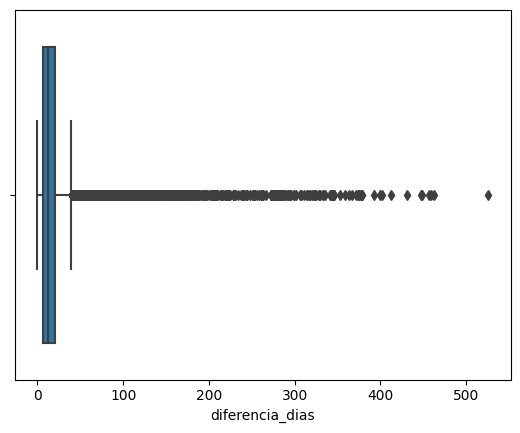

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(users_df["diferencia_dias"])

In [38]:
def discretizar_dias(x):
    if x > 100:
        return "+100"
    else:
        return "-100"

users_df["discretos_dias"] = users_df["diferencia_dias"].apply(discretizar_dias)

In [40]:
users_df["discretos_dias"].value_counts()

-100    20747
+100      468
Name: discretos_dias, dtype: int64

In [53]:
limite = 100
df_limit = users_df[users_df['diferencia_dias']<limite]

filtro1 = df_limit.target == 1 #me quedo con un dataset de morosos
filtro2 = df_limit.target == 0 #me quedo con un dataset de pagadores

/home/fede/.pyenv/versions/3.10.6/envs/default/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/fede/.pyenv/versions/3.10.6/envs/default/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


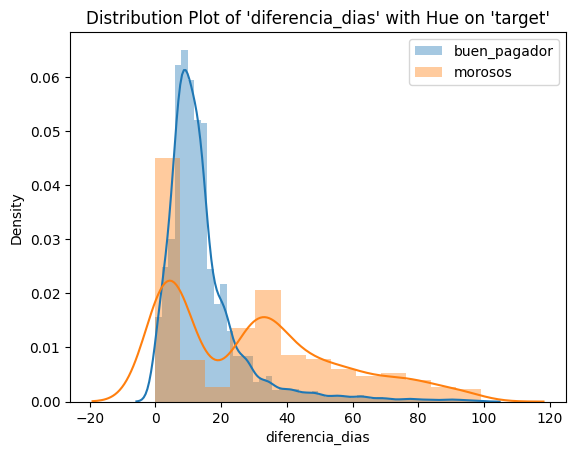

In [54]:
sns.distplot(df_limit[filtro2]['diferencia_dias'], label="buen_pagador")
sns.distplot(df_limit[filtro1]['diferencia_dias'], label="morosos")

plt.title("Distribution Plot of 'diferencia_dias' with Hue on 'target'")
plt.legend()
plt.show()
